In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, LSTM, Input, Dot, Activation
from keras.callbacks import EarlyStopping
from scipy.signal import lfilter

# Fuzzy Discrete Kalman Filter
class FuzzyDiscreteKalmanFilter:
    def __init__(self, n, m, p, q, r):
        self.n = n  # Number of states
        self.m = m  # Number of measurements
        self.p = p  # Process noise covariance
        self.q = q  # Measurement noise covariance
        self.r = r  # State estimate covariance
        self.x_hat = np.zeros((n, 1))  # Initial state estimate
        self.P = np.eye(n)  # Initial state estimate covariance

    def predict(self):
        self.x_hat_minus = self.x_hat
        self.P_minus = self.P + self.p

    def update(self, z):
        K = self.P_minus / (self.P_minus + self.q)  # Kalman gain
        self.x_hat = self.x_hat_minus + K.dot(z - self.x_hat_minus)  # Updated state estimate
        self.P = (np.eye(self.n) - K).dot(self.P_minus)  # Updated state estimate covariance

# Hybrid model with attention mechanism
def create_hybrid_model(input_shape, units=20):
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(units, activation='relu', return_sequences=True)(inputs)
    attention = Dense(1, activation='tanh')(lstm_out)
    attention = Activation('softmax')(attention)
    context = Dot(axes=1)([attention, lstm_out])
    outputs = Dense(2)(context)  # Output includes power for both levels of storage
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Train the hybrid model
def train_hybrid_model(X_train, y_train):
    model = create_hybrid_model(X_train.shape[1:])
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto', restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=False)
    return model, history

# Predict using the hybrid model with adjustments for storage power
def predict_hybrid_model(X, rnn_model, fdkf, P_mt_ref, P_st_ref):
    rnn_predictions = rnn_model.predict(X)
    fdkf_predictions = []
    for x in X:
        fdkf.predict()
        fdkf_predictions.append(fdkf.x_hat.flatten())
    fdkf_predictions = np.array(fdkf_predictions)

    # Ensure fdkf_predictions has the same number of samples as rnn_predictions
    num_samples = rnn_predictions.shape[0]
    fdkf_predictions = fdkf_predictions[:num_samples]

    # Adjust the power output using the division of power between short-term and medium-term storage levels
    adjusted_predictions = np.zeros_like(rnn_predictions)
    adjusted_predictions[:, 0, 0] = (rnn_predictions[:, 0, 0] + fdkf_predictions[:, 0]) / 2  # Add short-term storage power output
    adjusted_predictions[:, 0, 1] = (rnn_predictions[:, 0, 1] + fdkf_predictions[:, 1]) / 2  # Add medium-term storage power output

    adjusted_predictions[:, 0, 0] += P_st_ref[:num_samples].flatten()  # Add short-term storage power output
    adjusted_predictions[:, 0, 1] += P_mt_ref[:num_samples].flatten()  # Add medium-term storage power output

    return adjusted_predictions

# Load dataset
df = pd.read_csv("Location1.csv")

# Extract power data
power_data = df["Power"].values.reshape(-1, 1)  # Reshape to 2D array for compatibility with LSTM input

# Generate synthetic power reference signals for storage levels
T_mt = 0.1  # Example time constant for medium-term storage
b = [1 / (1 + T_mt)]  # Numerator coefficients of the transfer function
a = [1, -T_mt / (1 + T_mt)]  # Denominator coefficients of the transfer function
P_mt_ref = lfilter(b, a, power_data, axis=0)  # Medium-term power reference
P_st_ref = power_data - P_mt_ref  # Short-term power reference

# Prepare training data
window_size = 10  # Example window size for LSTM
X_train, y_train = [], []
for i in range(len(power_data) - window_size):
    X_train.append(power_data[i:i+window_size])
    y_train.append(power_data[i+window_size])
X_train, y_train = np.array(X_train), np.array(y_train)

# Train the hybrid model
hybrid_model, history = train_hybrid_model(X_train, y_train)

# Create FDKF object
fdkf = FuzzyDiscreteKalmanFilter(n=3, m=1, p=0.1, q=0.1, r=0.1)

# Make predictions using the hybrid model
predictions = predict_hybrid_model(X_train, hybrid_model, fdkf, P_mt_ref, P_st_ref)

# Print predictions
# print("Predictions:", predictions)

Restoring model weights from the end of the best epoch: 3.
Epoch 13: early stopping
1369/1369 [==============================] - 4s 3ms/step


In [ ]:
pred_df = pd.DataFrame(predictions[:, 0])
pred_array = np.array(pred_df[1])

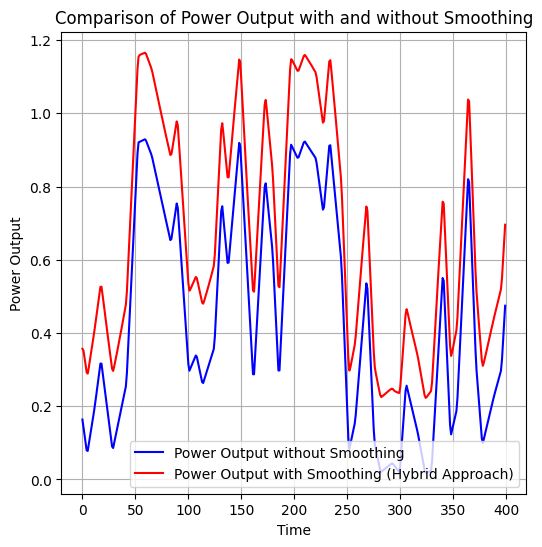

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

# Plot power output without smoothing
plt.plot(df['Power'][:400], label='Power Output without Smoothing', color='blue')

# Plot total power output after smoothing
plt.plot(pred_array[:400], label='Power Output with Smoothing (Hybrid Approach)', color='red')

plt.xlabel('Time')
plt.ylabel('Power Output')
plt.title('Comparison of Power Output with and without Smoothing')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-73-9731ce3fc0e3>:4: RuntimeWarning: invalid value encountered in divide
  percentage_change = np.abs((power_data[i] - power_data[i-1]) / power_data[i-1]) * 100
<ipython-input-73-9731ce3fc0e3>:4: RuntimeWarning: divide by zero encountered in divide
  percentage_change = np.abs((power_data[i] - power_data[i-1]) / power_data[i-1]) * 100


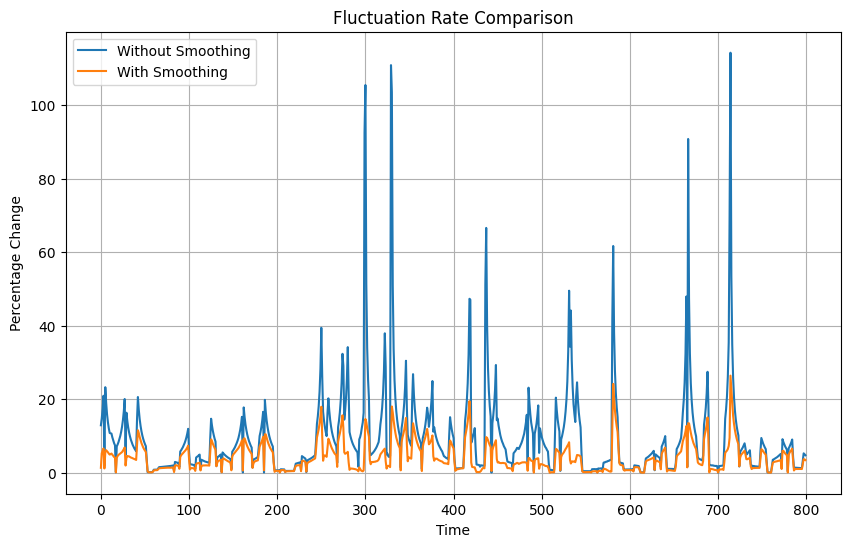

In [ ]:
# Calculate percentage change for power data without smoothing
percentage_change_without_smoothing = []
for i in range(1, len(power_data)):
    percentage_change = np.abs((power_data[i] - power_data[i-1]) / power_data[i-1]) * 100
    percentage_change_without_smoothing.append(percentage_change)

# Calculate percentage change for power data with smoothing
percentage_change_with_smoothing = []
for i in range(1, len(predictions)):
    percentage_change = np.abs((predictions[i] - predictions[i-1]) / predictions[i-1]) * 100
    percentage_change_with_smoothing.append(percentage_change[0][1])

# Plot fluctuation rate for both cases
plt.figure(figsize=(10, 6))
plt.plot(percentage_change_without_smoothing[:800], label='Without Smoothing')
plt.plot(percentage_change_with_smoothing[:800], label='With Smoothing')
plt.xlabel('Time')
plt.ylabel('Percentage Change')
plt.title('Fluctuation Rate Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def calculate_mape(actual, predicted):
    # Calculate absolute percentage error for each value
    abs_percentage_error = np.abs((actual - predicted) / actual)

    # Replace infinity values with NaN
    abs_percentage_error[abs_percentage_error == np.inf] = np.nan

    # Calculate the mean of absolute percentage errors, ignoring NaN values
    mape = np.nanmean(abs_percentage_error) * 100

    return mape

# Calculate MAPE for both cases
mape_without_smoothing = calculate_mape(power_data[1:], power_data[:-1])
mape_with_smoothing = calculate_mape(predictions[1:], predictions[:-1])

print("MAPE without smoothing:", mape_without_smoothing)
print("MAPE with smoothing:", mape_with_smoothing)

# Calculate percentage change
percentage_change = ((mape_with_smoothing - mape_without_smoothing) / mape_without_smoothing) * 100

print("Percentage Change: " + str(percentage_change) + "%")

MAPE without smoothing: 11.768280684823212
MAPE with smoothing: 2.564915269613266
Percentage Change: -78.20484284572622%


In [ ]:
hybrid_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 10, 1)]              0         []                            
                                                                                                  
 lstm_5 (LSTM)               (None, 10, 20)               1760      ['input_6[0][0]']             
                                                                                                  
 dense_10 (Dense)            (None, 10, 1)                21        ['lstm_5[0][0]']              
                                                                                                  
 activation_5 (Activation)   (None, 10, 1)                0         ['dense_10[0][0]']            
                                                                                            

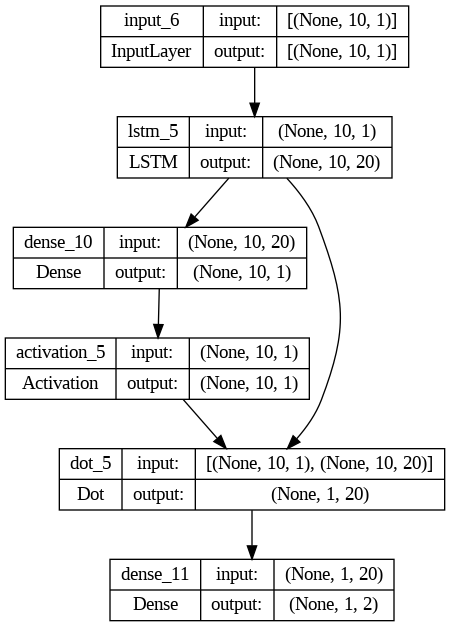

In [ ]:
from keras.utils import plot_model

plot_model(hybrid_model, show_shapes=True)